# 프로젝트: CAM을 만들고 평가해 보자

프로젝트 제출 루브릭

| 평가 기준 | 달성 여부 및 설명 |
|-----------|--------------------|
| CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가? | ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다. |
| 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가? | CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다. |
| 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가? | CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다. |

# 목차
1. Data & Library
2. Image 살펴보기
3. 기능들 구현하기
    1. CAM 구현하기
    2. Grad-CAM 구현하기
    3. Bounding Box 구현하기
    4. IoU 구현하기
4. Model 구현하기
    1. Model 구현하기
    2. 학습하기
    3. 학습 성능 보기
5. 시각화 하기
    1. CAM 시각화
    2. Grad-CAM 시각화
    3. CAM과 Grad-CAM 비교 시각화
6. Object Localization

# 1. Data & Library

In [1]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 88.5 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
save_dir = 'data'
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory '{save_dir}' created.")
    
# img_tar = os.path.join(save_dir, 'images.tar')
# ann_tar = os.path.join(save_dir, 'annotation.tar')
# list_tar = os.path.join(save_dir, 'lists.tar')

# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -O {img_tar}
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -O {ann_tar}
# !wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -O {list_tar}

# !tar -xf {img_tar} -C {save_dir}
# !tar -xf {ann_tar} -C {save_dir}
# !tar -xf {list_tar} -C {save_dir}

# !rm {img_tar}
# !rm {ann_tar}
# !rm {list_tar}

In [3]:
import random

import shutil
import scipy.io as sio

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import cv2
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# 원본 데이터 경로 (압축 해제 후 폴더)
images_dir = os.path.join('data/Images')   # 이미지들이 위치한 폴더
mat_dir = os.path.join('data')   # 프로젝트 루트 디렉토리

# .mat 파일 경로 (train_list.mat와 test_list.mat가 각각 같은 구조라고 가정)
train_mat_path = os.path.join(mat_dir, 'train_list.mat')
test_mat_path = os.path.join(mat_dir, 'test_list.mat')

# .mat 파일 로드
train_mat = sio.loadmat(train_mat_path)
test_mat = sio.loadmat(test_mat_path)

# train_mat와 test_mat 내부에 'file_list'와 'labels' 등이 있음
train_file_list = train_mat['file_list']
train_labels = train_mat['labels'].squeeze()  # (N,)
test_file_list = test_mat['file_list']
test_labels = test_mat['labels'].squeeze()

# 최종적으로 ImageFolder 구조로 재구성할 대상 폴더 생성 (예: stanford_dogs/train, stanford_dogs/test)
base_dir = 'stanford_dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def process_mat_file(file_list_array, split_dir):
    """
    .mat 파일에서 로드한 file_list_array를 사용해,
    split_dir(예: train 혹은 test)에 클래스별 폴더를 생성하고 이미지를 복사합니다.
    """
    num_files = file_list_array.shape[0]
    for idx in range(num_files):
        # file_list_array[idx]는 보통 array([<파일경로>]) 형태입니다.
        # 따라서, array([<파일경로>]).item()을 사용하면 실제 문자열을 얻을 수 있습니다.
        file_path = file_list_array[idx][0].item()

        # 혹시 bytes 타입이면 문자열로 디코딩
        if isinstance(file_path, bytes):
            file_path = file_path.decode('utf-8')

        # 파일 경로 예시: 'n02116738-African_hunting_dog/n02116738_2988.jpg'
        # 클래스 이름은 파일 경로의 최상위 폴더명 (예: 'n02116738-African_hunting_dog')
        class_folder = file_path.split('/')[0]

        # 대상 클래스 폴더 생성
        dest_folder = os.path.join(split_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        # 원본 이미지 경로: Images 폴더 아래에 file_path 위치
        src_path = os.path.join(images_dir, file_path)
        # 대상 이미지 경로: dest_folder 아래에 원본 파일명 그대로 복사
        dest_path = os.path.join(dest_folder, os.path.basename(file_path))

        # 파일 존재 여부 확인 후 복사
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found: {src_path}")

print("Processing train set...")
process_mat_file(train_file_list, train_dir)
print("Processing test set...")
process_mat_file(test_file_list, test_dir)

print("Dataset reorganization complete.")

Processing train set...
Processing test set...
Dataset reorganization complete.


In [5]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]

        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')

annotation_dir = os.path.join(os.getenv("HOME"), 'work/class_activation_map/Annotation')

train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


# 2. Image 살펴보기

In [7]:
def visualize(sample):
    img_tensor, label, bbox = sample

    print("Label index:", label)
    print("Class name:", train_dataset.classes[label])

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.title(f"Class: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

Label index: 0
Class name: n02085620-Chihuahua


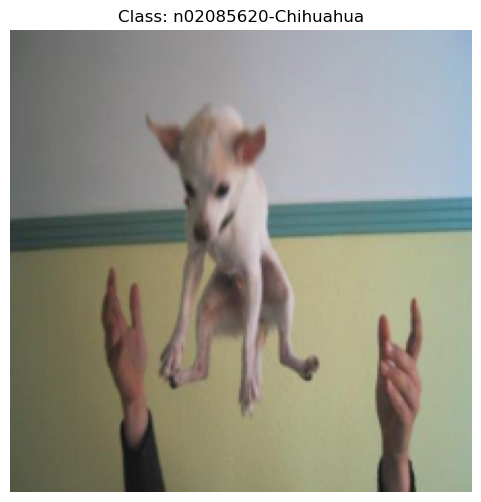

In [8]:
train_sample = train_dataset[0]

visualize(train_sample)

# 3. 기능들 구현하기

## CAM(Class Activation Map) 생성 과정 정리

CAM을 생성하기 위해서는 다음의 세 가지 핵심 요소가 필요하다.

### Step 1. 특성 맵(Feature Map)

모델의 특정 합성곱 계층(여기서는 *layer4*)에서 추출되는 공간적 특징 정보이다.
입력 이미지의 패턴, 구조, 객체 형태 등이 이 특성 맵에 담겨 있다.

### Step 2. Softmax 직전 분류기(FC Layer)의 가중치

Fully-connected layer는 각 클래스가 어떤 특징 채널에 의존하는지를 학습한다.
따라서 FC 가중치는 “특정 클래스가 어떤 feature map 채널을 얼마나 중요하게 사용하는지”를 나타낸다.

### Step 3. 원하는 클래스의 출력값

CAM은 특정 클래스에 대한 주목 영역을 시각화하는 것이기 때문에,
예측 결과 중 가장 높은 클래스를 선택하거나, 관심 있는 특정 클래스를 직접 지정해서 사용한다.

---

## CAM 계산 과정

### Step 1. 특정 레이어의 출력(Feature Map) 저장

* `model.layer4`에 **forward hook**을 등록해,
* 이미지가 네트워크를 통과하는 과정에서 해당 레이어의 출력(feature map)을 리스트에 저장한다.

### Step 2. 모델 예측 및 클래스 선택

* 입력 이미지를 모델에 넣어 feedforward 실행.
* 배치 첫 번째 이미지의 예측 결과 중 가장 높은 점수를 가진 클래스를 선택한다.
  → CAM은 이 클래스에 대한 주목 영역을 의미하게 된다.

### Step 3. FC 가중치와 Feature Map의 가중합으로 CAM 계산

* 선택한 클래스에 대응하는 **FC layer의 가중치 벡터**를 가져온다.
* 저장된 feature map의 채널별로 이 가중치를 곱하고 더해준다.
  → 즉, “클래스 A는 어떤 채널을 얼마나 중요하게 보았는가”를 반영하는 선형 결합이다.
* 이렇게 생성된 2D 맵이 바로 CAM이다.

### Step 4. 정규화 및 시각화

* ReLU로 음수를 제거한다.
* 최소/최대 값을 이용해 0~1 구간으로 정규화한다.
* 필요하다면 `cv2.resize()` 등을 사용하여 입력 이미지 크기로 업샘플링해 시각화한다.


## 3-1. CAM 구현하기

In [9]:
def unnormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

Hook 함수 개념 (봐도봐도 까먹네...)
1. register_forward_hook :
    - forward pass를 하는 동안 (output이 계산할 때 마다) 만들어놓은 hook function을 호출.
    - 이렇게 등록한 함수에 인자로 모듈이 실행되기 전 입력값과 실행 후 출력값을 받음 (input, output)

2. register_forward_pre_hook :
    - forward pass를 하기 직전에 hook function을 호출.
    - 이렇게 등록한 함수에 인자로 모듈이 실행되기 전 입력값만을 받음 (input)

3. register_full_backward_hook :
    - backward pass를 하는 동안 (gradient가 계산될 때마다) hook function을 호출.
    - 이렇게 등록한 함수에 인자로 backpropagation에서의 gradient 값들을 받음 (grad_input, grad_output)
4. register_backward_hook
    - backward pass 과정에서(gradient가 해당 모듈을 지나갈 때) hook function을 호출.
    - 등록한 hook 함수는 그 모듈의 gradient가 계산된 직후 실행되며, 인자로 grad_input, grad_output 을 받는다.

In [10]:
def generate_cam(model, image):
    model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.detach())
    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    pred_class = output.argmax(dim=1).item()

    fc_weights = model.fc.weight.data.to(image.device)

    fmap = features[0][0] 
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

In [11]:
def visualize_cam(cam):
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off') 
    plt.show()

In [12]:
def visualize_cam_on_image(cam, img, alpha=0.5):
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("CAM Overlay on Image")
    plt.axis('off')
    plt.show()

In [13]:
# 사용 예시

# image, label, bbox = train_dataset[0]
# sample_image = image.unsqueeze(0).to(device)
# model = torch.load(cam_model_path, weights_only=False)

# cam = generate_cam(model, sample_image)
# plt.imshow(cam_image)

# visualize_cam(cam)

# orig_img = unnormalize(image)
# visualize_cam(cam)
# visualize_cam_on_image(cam, orig_img)

## 3-2. Grad-CAM 구현하기
마찬가지로 위에서 Hook 개념 부분에서 CAM과 달리 두개가 필요한 Grad-CAM은 
- forward의 Activation Map의 Weight
- Backward의 gradient를 활용한 feature map의 중요도

Grad-CAM은 **특정 레이어의 feature map**과 **관심 클래스의 예측값 그래디언트**를 이용해,
모델이 어떤 공간적 영역에 주목했는지 시각화하는 방법입니다.

---

### 핵심 흐름

1. **관찰할 레이어 선택**

   * 원하는 합성곱 레이어(`activation_layer`)를 hook으로 추출.

2. **feature map과 gradient 수집**

   * forward hook → feature map 저장
   * backward hook → 해당 레이어의 gradient 저장

3. **채널별 가중치 계산**

   * gradient에 GAP 적용 → 채널별 중요도(weight) 계산

4. **CAM 생성**

   * weight와 feature map의 가중합 → ReLU 적용 → CAM 완성
   * 필요 시 입력 이미지 크기로 업샘플링

---

### 정리

Grad-CAM은 선택한 레이어에서 **그래디언트를 통해 채널별 중요도를 구하고**,
이를 feature map에 가중합해 **모델이 클래스 판단에 주목한 영역**을 시각화하는 방법입니다.
CAM과 달리 **임의의 레이어**에서도 적용 가능하다는 장점이 있습니다.


In [14]:
def generate_grad_cam(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    def forward_hook(module, input, output):
        features['value'] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(image)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    forward_handle.remove()
    backward_handle.remove()

    fmap = features['value'][0]
    grads = gradients['value'][0]

    weights = torch.mean(grads, dim=(1, 2))

    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

In [15]:
# 사용 예시

# grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

# visualize_cam(grad_cam)

# orig_img = unnormalize(image)
# visualize_cam_on_image(grad_cam, orig_img)

## 3-3. Bounding Box 구하기

In [16]:
def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None

    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

In [17]:
def visualize_bbox_on_image(img, bbox, box_color=(255, 0, 0), thickness=2):

    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

In [18]:
# 사용 예시

# cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
# bbox = get_bbox(cam_resized, threshold=0.5)

# img_bbox = visualize_bbox_on_image(orig_img, bbox)
# plt.figure(figsize=(6,6))
# plt.imshow(img_bbox)
# plt.title("Image with Bounding Box from CAM")
# plt.axis("off")
# plt.show()

## 3-4. IoU(Intersection over Union) 구하기



Bounding Box를 활용한 객체 검출 성능을 평가할 때 **IoU**가 자주 사용된다.

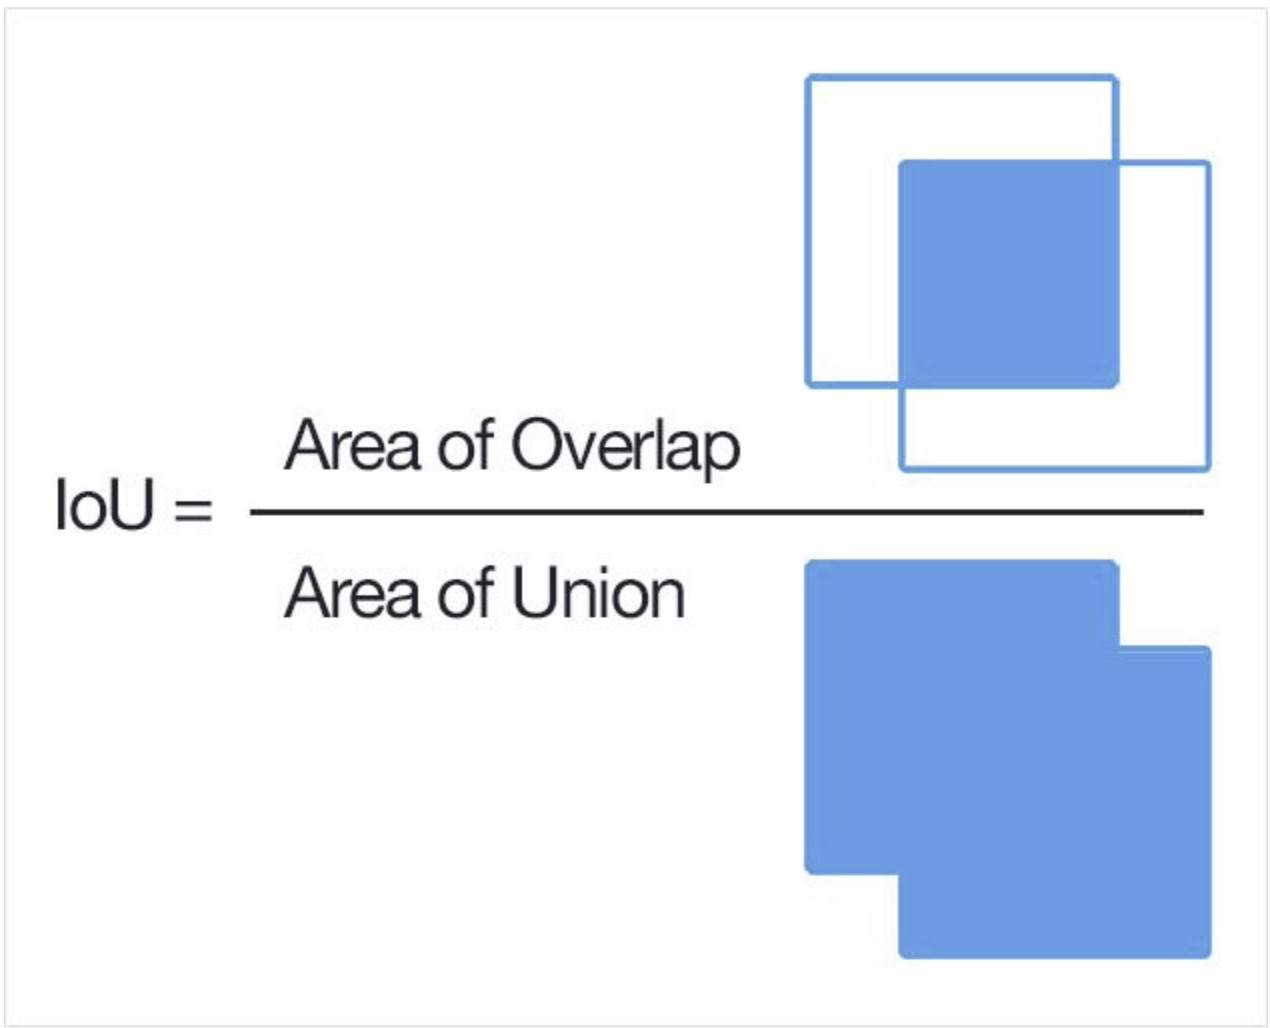

IoU(Intersection over Union)는 **두 영역의 교집합(intersection) 넓이를 합집합(union) 넓이로 나눈 값**

$$
\text{IoU} = \frac{\text{Intersection 영역}}{\text{Union 영역}}
$$

이 지표는 객체의 절대적인 크기와 상관없이, 모델이 얼마나 정확하게 해당 영역을 찾았는지를 **상대적인 비율**로 평가할 수 있게 해준다.
따라서 **모델의 영역 탐지 성능 비교에 매우 유용한 지표**ㅇ;다.

In [19]:
def get_iou(gt_bbox, pred_bbox):
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = gt_bbox
    x_min2, y_min2, x_max2, y_max2 = pred_bbox

    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

In [20]:
def visualize_both_bbox_on_image(img, bbox, ground_truth, thickness=2):
    img_with_bbox = img.copy()

    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)

    return img_with_bbox

In [ ]:
# 사용 예시

# ground_truth = [int(x) for x in ground_bbox]

# img_bbox = visualize_both_bbox_on_image(orig_img, bbox, ground_truth)

# plt.figure(figsize=(6,6))
# plt.imshow(img_bbox)
# plt.title("Compare with Ground Truth")
# plt.axis("off")
# plt.show()

# 4. Model 구현하기
- ResNet50 + GAP + DenseLayer -> CAM 모델로 학습하기

## 4-1. Model 구현하기

In [40]:
from torchvision.models import resnet50, ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

## 4-2. 학습하기

In [41]:
import time

def train(model, train_loader, val_loader, epochs, checkpoint_path=None):
    save_dir = 'model'
    os.makedirs(save_dir, exist_ok=True)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
    
    model.to(device)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'epoch_time': []
    }

    # -------------------------------
    # 체크포인트 불러오기
    # -------------------------------
    start_epoch = 0
    best_val_acc = 0.0
    latest_path = f'{save_dir}/cam_resnet50_latest.pth'
    best_path = f'{save_dir}/cam_resnet50_best.pth'

    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            history = checkpoint.get('history', history)
            start_epoch = checkpoint['epoch'] + 1

            # 기존 best 모델 기록이 있다면 불러오기
            if os.path.exists(best_path):
                best_ckpt = torch.load(best_path)
                best_val_acc = best_ckpt.get('val_acc', 0)

            print(f"Training resumed from epoch {start_epoch}")
            print(f"Current best Val Acc: {best_val_acc:.2f}%")

        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting from scratch.")
            start_epoch = 0

    # -------------------------------
    # Training Loop
    # -------------------------------
    for epoch in range(start_epoch, epochs):
        start_time = time.time()

        # ============ Train ============
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels, bboxes in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100. * correct / total

        # ============ Validation ============
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels, bboxes in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / total
        val_acc = 100. * correct / total

        epoch_time = time.time() - start_time

        # 기록 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"Time: {epoch_time/60:.1f} min")

        # ============ 최신 체크포인트 저장 ============
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }, latest_path)

        # ============ Best 모델 저장 ============  
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'val_acc': val_acc,
                'model_state_dict': model.state_dict()
            }, best_path)

            print(f" New Best Model Saved! | Val Acc: {val_acc:.2f}%")

    print("Training finished!")
    print(f"Best model saved at: {best_path}, Acc = {best_val_acc:.2f}%")

    return history


In [42]:
# 일부로 멈춘 것임. 오류 아님
# 일부로 멈춰서 KeyboardInterrupt
# 어차피 checkpoints와 best model은 저장되어있어 불러오면 됨

EPOCH = 40

history = train(model, train_loader, valid_loader, EPOCH)

Epoch [1/40] | Train Loss: 4.6874, Train Acc: 4.56% | Val Loss: 4.5137, Val Acc: 16.71% | Time: 2.5 min
 New Best Model Saved! | Val Acc: 16.71%
Epoch [2/40] | Train Loss: 4.0644, Train Acc: 40.81% | Val Loss: 3.4526, Val Acc: 64.57% | Time: 2.5 min
 New Best Model Saved! | Val Acc: 64.57%
Epoch [3/40] | Train Loss: 3.0923, Train Acc: 62.45% | Val Loss: 2.4039, Val Acc: 74.28% | Time: 2.5 min
 New Best Model Saved! | Val Acc: 74.28%
Epoch [4/40] | Train Loss: 2.3026, Train Acc: 70.20% | Val Loss: 1.6536, Val Acc: 78.67% | Time: 2.5 min
 New Best Model Saved! | Val Acc: 78.67%
Epoch [5/40] | Train Loss: 1.7288, Train Acc: 75.23% | Val Loss: 1.2232, Val Acc: 81.47% | Time: 2.5 min
 New Best Model Saved! | Val Acc: 81.47%
Epoch [6/40] | Train Loss: 1.3327, Train Acc: 78.82% | Val Loss: 0.9647, Val Acc: 83.09% | Time: 2.5 min
 New Best Model Saved! | Val Acc: 83.09%
Epoch [7/40] | Train Loss: 1.0480, Train Acc: 82.21% | Val Loss: 0.8159, Val Acc: 84.27% | Time: 2.5 min
 New Best Model Save

KeyboardInterrupt: 

In [48]:
best_ckpt = torch.load("model/cam_resnet50_best.pth")
model.load_state_dict(best_ckpt["model_state_dict"])

<All keys matched successfully>

## 4-3. 학습 성능 보기

In [43]:
def load_history_from_checkpoint(checkpoint_path):
    """
    체크포인트 파일에서 history 딕셔너리만 불러옵니다.
    """
    if not os.path.exists(checkpoint_path):
        print(f"Error: 체크포인트 파일이 존재하지 않습니다: {checkpoint_path}")
        return None
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        if 'history' in checkpoint:
            print(f"History 로드 완료: {checkpoint_path}")
            return checkpoint['history']
        else:
            print(f"Warning: 체크포인트 파일에 'history' 키가 없습니다. None을 반환합니다.")
            return None
            
    except Exception as e:
        print(f"Error 로드 중 오류 발생: {e}")
        return None

In [44]:
def plot_history_v2(history, title="Training History", figsize=(12, 10)):
    """
    단일 history 딕셔너리를 받아 2x2 서브플롯 형태로 학습 결과를 시각화합니다.
    (Train Acc, Valid Acc, Train Loss, Valid Loss)

    Args:
        history (dict): 학습 history 딕셔너리.
        title (str): 전체 제목.
        figsize (tuple): 그림 크기.
    """
    
    if not history:
        print("History 데이터가 비어 있습니다.")
        return

    try:
        epochs = len(history['train_loss'])
    except KeyError:
        print("History 딕셔너리 키가 잘못되었습니다. 'train_loss' 등이 필요합니다.")
        return
        
    if epochs == 0:
        print("History가 비어 있습니다 (0 에폭).")
        return
    
    x_data = range(1, epochs + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    plt.suptitle(title, fontsize=18, y=1.02)

    plot_info = [
        ('train_acc', 'Train Accuracy', axes[0, 0], 'Accuracy (%)'),
        ('val_acc', 'Validation Accuracy', axes[0, 1], 'Accuracy (%)'),
        ('train_loss', 'Train Loss', axes[1, 0], 'Loss Value'),
        ('val_loss', 'Validation Loss', axes[1, 1], 'Loss Value')
    ]

    for key, plot_title, ax, ylabel in plot_info:
        data = history.get(key, [])
        
        ax.plot(x_data, data, 
                label=key.replace('_', ' ').title(), 
                linestyle='-', marker='o', markersize=3)
        
        ax.set_title(plot_title, fontsize=14)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.set_xlim(1, epochs) 
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
    plt.show()

History 로드 완료: model/cam_resnet50_latest.pth


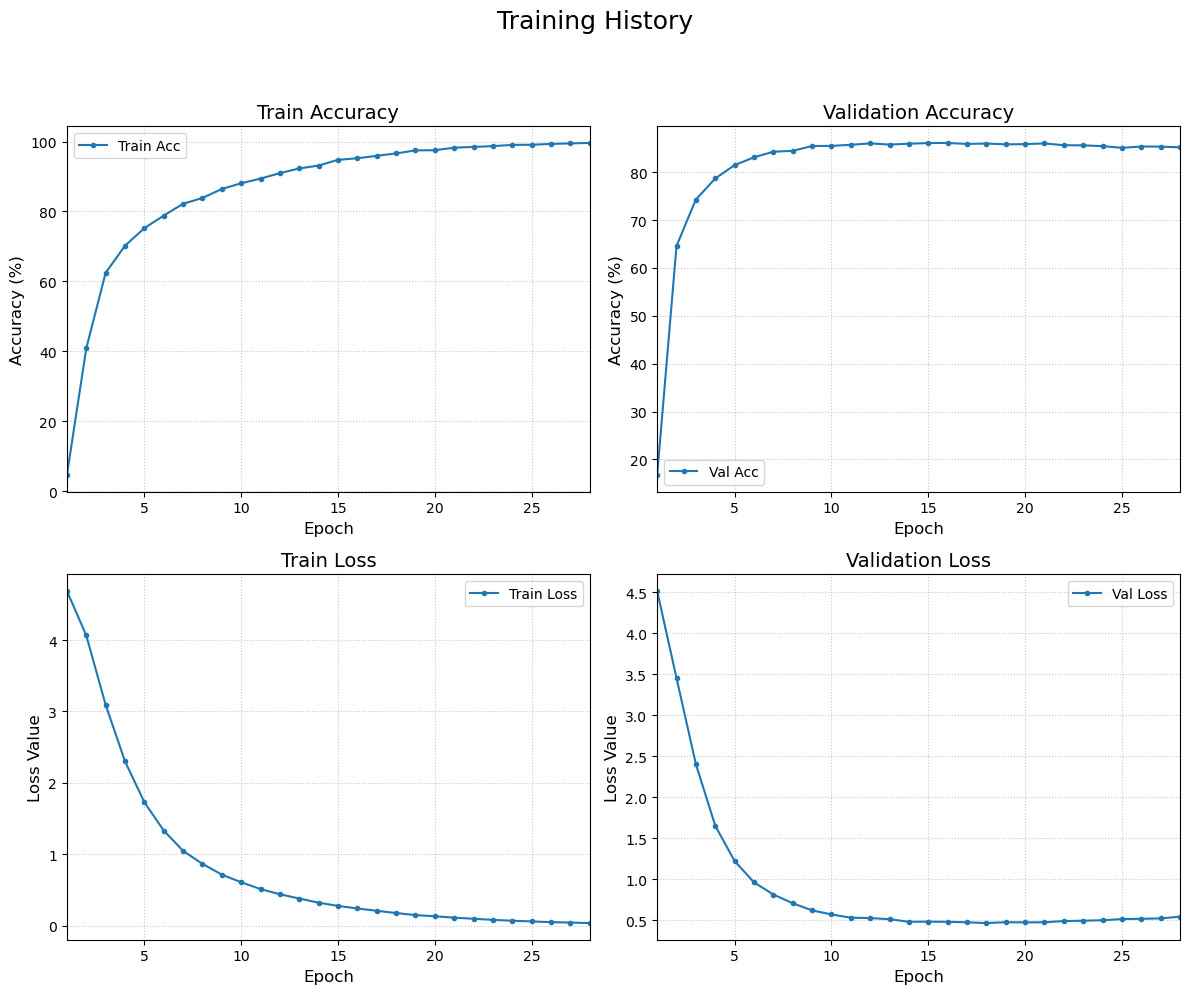

In [45]:
model_history = load_history_from_checkpoint('model/cam_resnet50_latest.pth')
plot_history_v2(model_history)

# 5. 시각화 하기

## 5-1. CAM 시각화

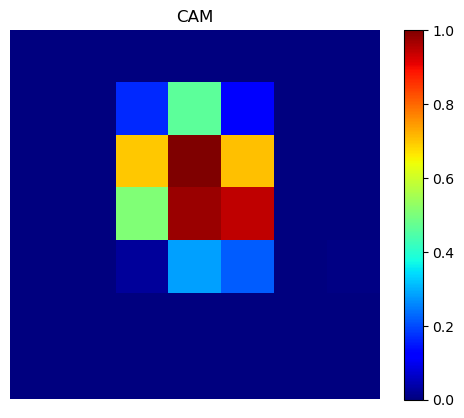

In [51]:
image, label, bbox = train_dataset[0]
sample_image = image.unsqueeze(0).to(device)

cam = generate_cam(model, sample_image)
visualize_cam(cam)

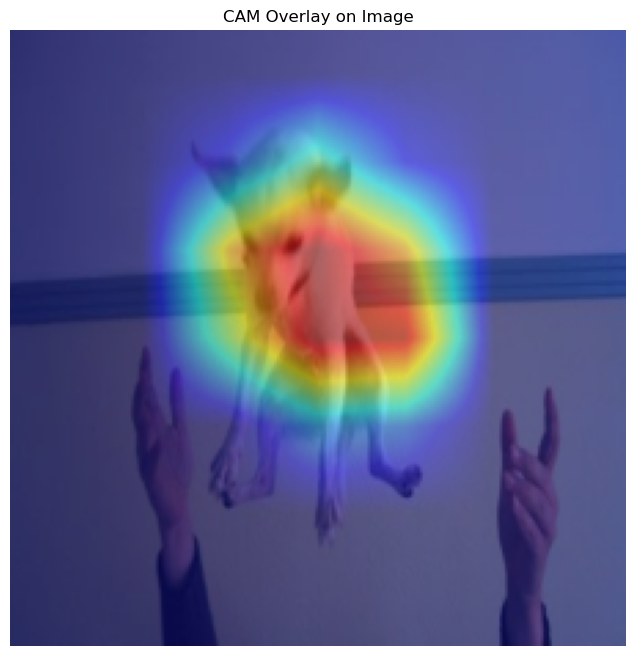

In [52]:
orig_img = unnormalize(image)
visualize_cam_on_image(cam, orig_img)

## 5-2. Grad-CAM 시각화

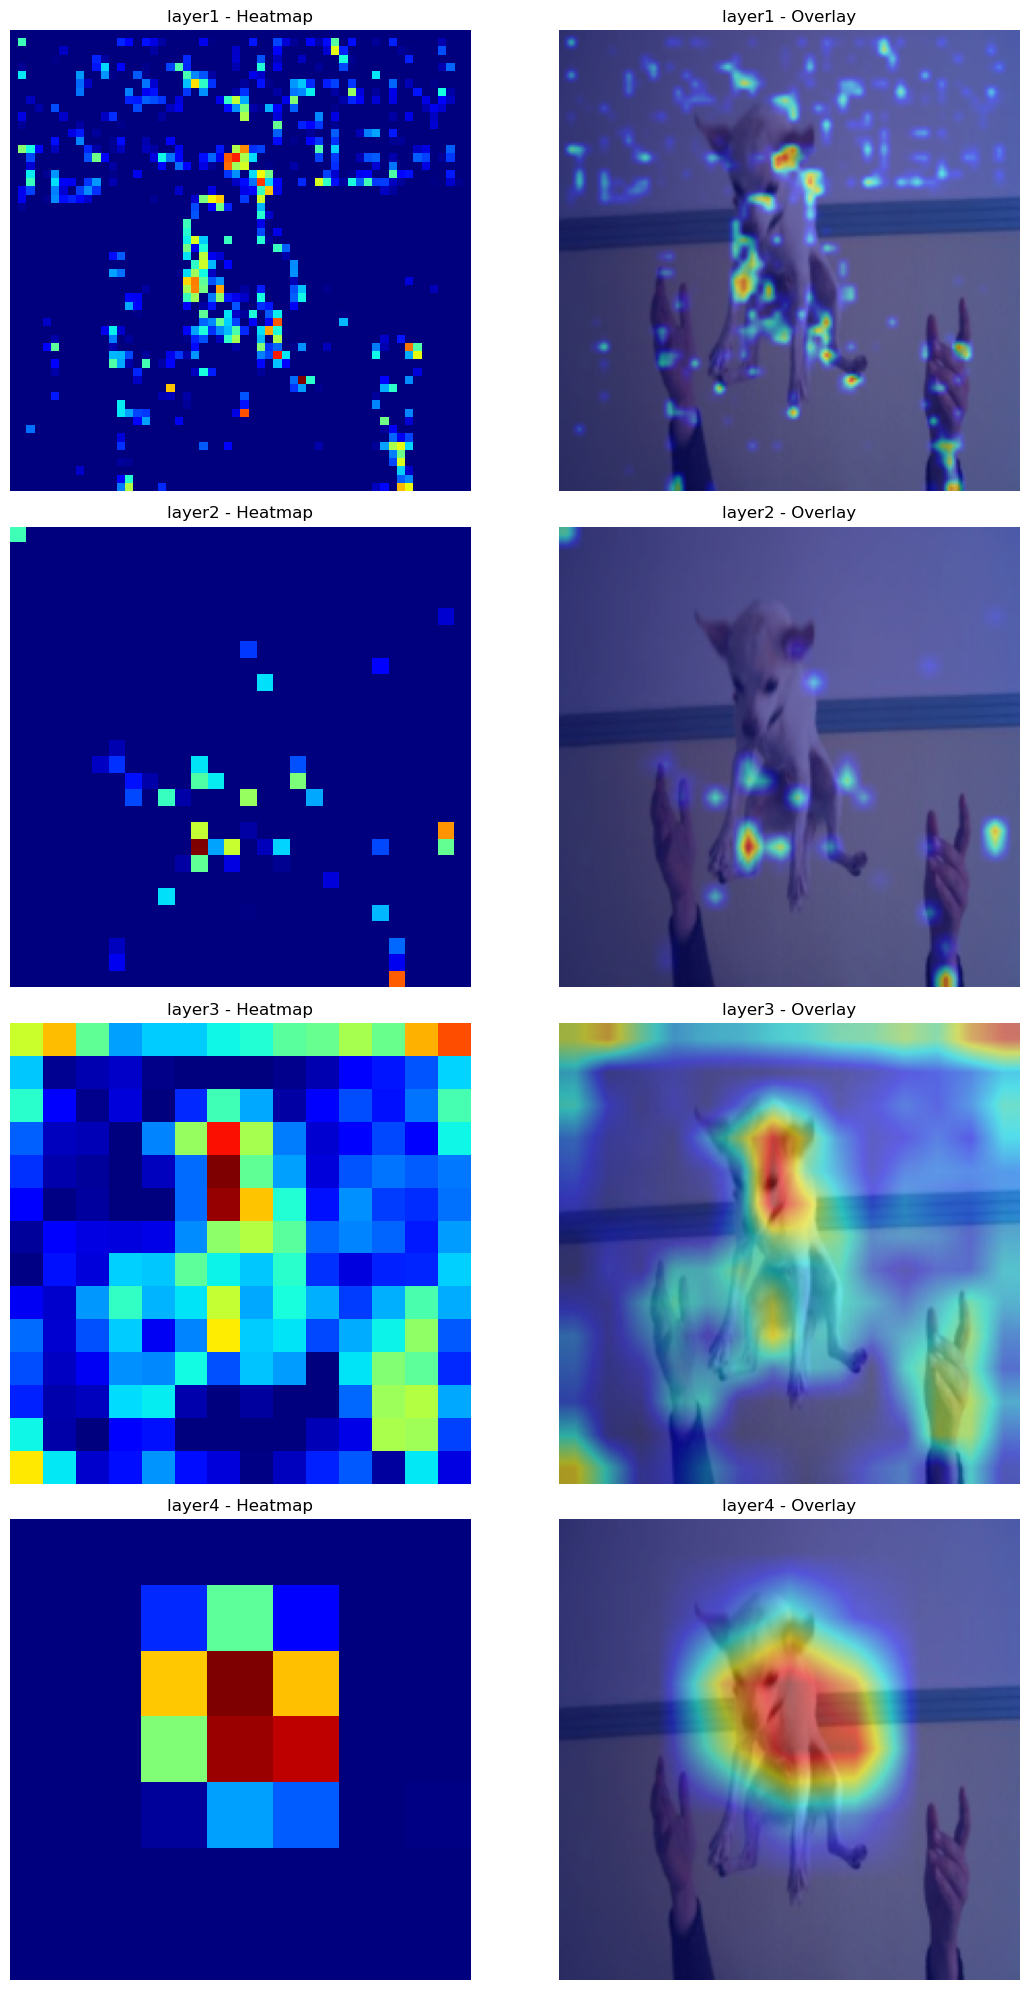

In [53]:
# 보기 편하게 하기 위해 subplots 사용
# 각 행마다 layer 층별로 시각화

fig, axes = plt.subplots(4, 2, figsize=(12, 20))
target_layers = ["layer1", "layer2", "layer3", "layer4"]

for i, layer in enumerate(target_layers):
    
    grad_cam = generate_grad_cam(model, sample_image, target_layer_name=layer)
    
    # ---------------------------------------------------------
    # 왼쪽 - CAM 히트맵 시각화 
    # ---------------------------------------------------------
    axes[i, 0].imshow(grad_cam, cmap='jet')
    axes[i, 0].set_title(f"{layer} - Heatmap")
    axes[i, 0].axis('off')
    
    # ---------------------------------------------------------
    # 오른쪽 - 원본 오버레이 시각화
    # ---------------------------------------------------------
    H, W, _ = orig_img.shape
    cam_resized = cv2.resize(grad_cam, (W, H))
    
    heatmap = (cam_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    img_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(img_bgr, 0.5, heatmap, 0.5, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
    axes[i, 1].imshow(overlay_rgb)
    axes[i, 1].set_title(f"{layer} - Overlay")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 5-3. CAM과 Grad-CAM 비교 시각화

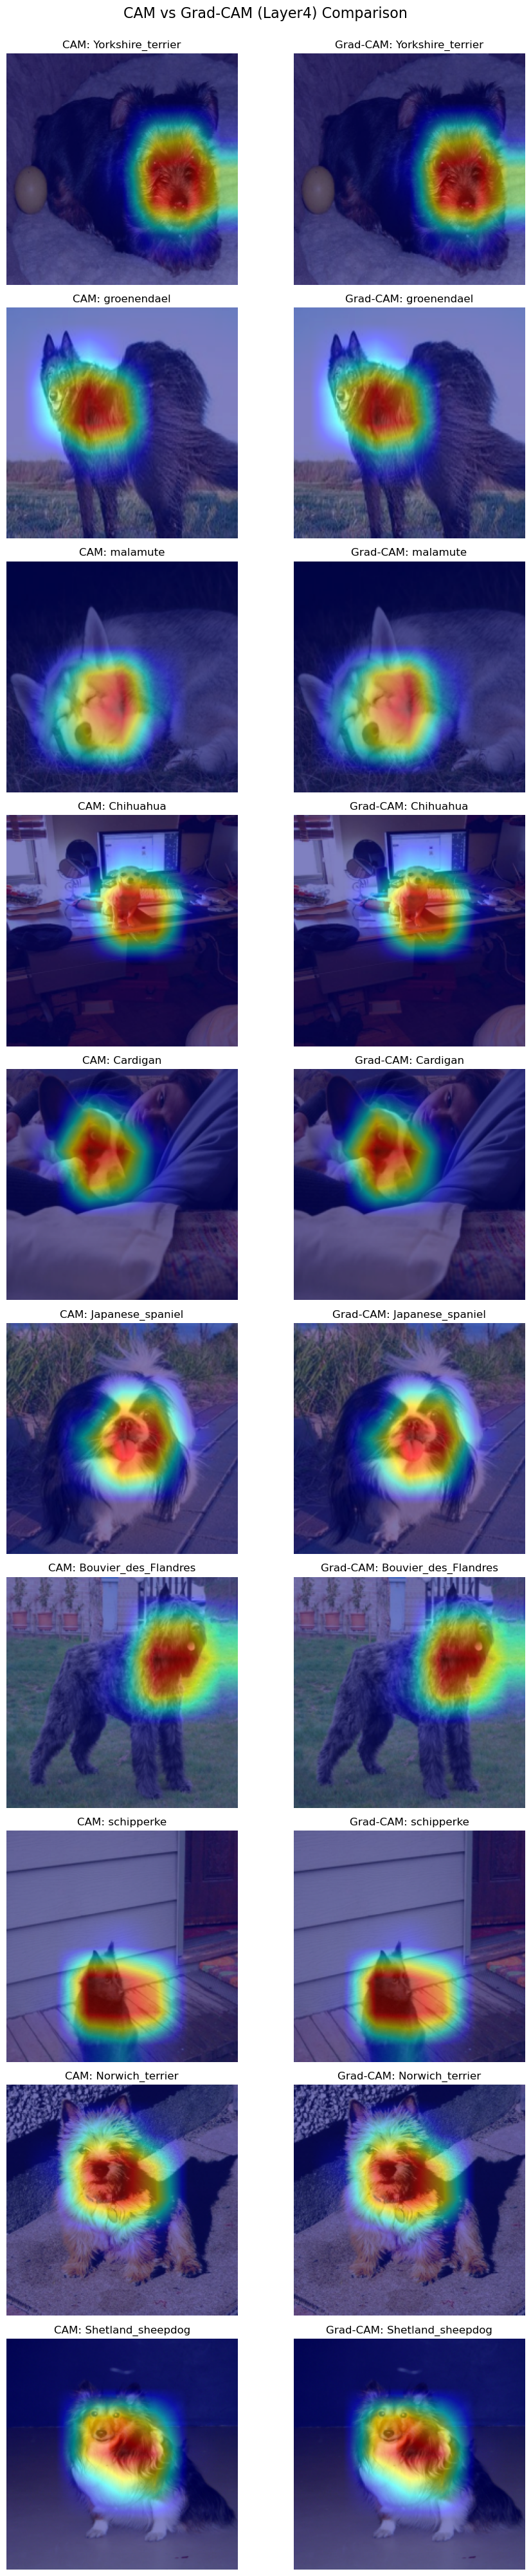

In [54]:
# 여러개 비교하기 위해 Valid 데이터에서 k개 만큼 랜덤으로 추출
# subplots 사용해서 각 이미지에 대한 CAM과 Grad-CAM을 비교하기 용이하게 배열

num_samples = 10
indices = random.sample(range(len(valid_dataset)), num_samples)

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
fig.suptitle(f"CAM vs Grad-CAM (Layer4) Comparison", fontsize=16, y=1.00)

model.eval()

for i, idx in enumerate(indices):
    img_tensor, label, _ = valid_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    orig_img_uint8 = (img_np * 255).astype(np.uint8)
    h, w, _ = orig_img_uint8.shape

    class_name = valid_dataset.classes[label].split('-')[-1]

    # ---------------------------------------------------------
    # 왼쪽 - CAM 시각화
    # ---------------------------------------------------------
    cam_result = generate_cam(model, input_tensor)
    
    if isinstance(cam_result, tuple):
        cam_map = cam_result[0]
    else:
        cam_map = cam_result
        
    cam_resized = cv2.resize(cam_map, (w, h))
    heatmap = (cam_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    img_bgr = cv2.cvtColor(orig_img_uint8, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(img_bgr, 0.5, heatmap, 0.5, 0)
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
    axes[i, 0].imshow(overlay_rgb)
    axes[i, 0].set_title(f"CAM: {class_name}")
    axes[i, 0].axis('off')

    # ---------------------------------------------------------
    # 오른쪽 - Grad-CAM (Layer4) 시각화
    # ---------------------------------------------------------
    grad_cam_map = generate_grad_cam(model, input_tensor, target_layer_name='layer4')
    
    cam_resized = cv2.resize(grad_cam_map, (w, h))
    heatmap = (cam_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    overlay = cv2.addWeighted(img_bgr, 0.5, heatmap, 0.5, 0)
    overlay_rgb = cv2.cvtColoㄴr(overlay, cv2.COLOR_BGR2RGB)
    
    axes[i, 1].imshow(overlay_rgb)
    axes[i, 1].set_title(f"Grad-CAM: {class_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# 6. object localization
- Bounding Box로 IoU 구해보기

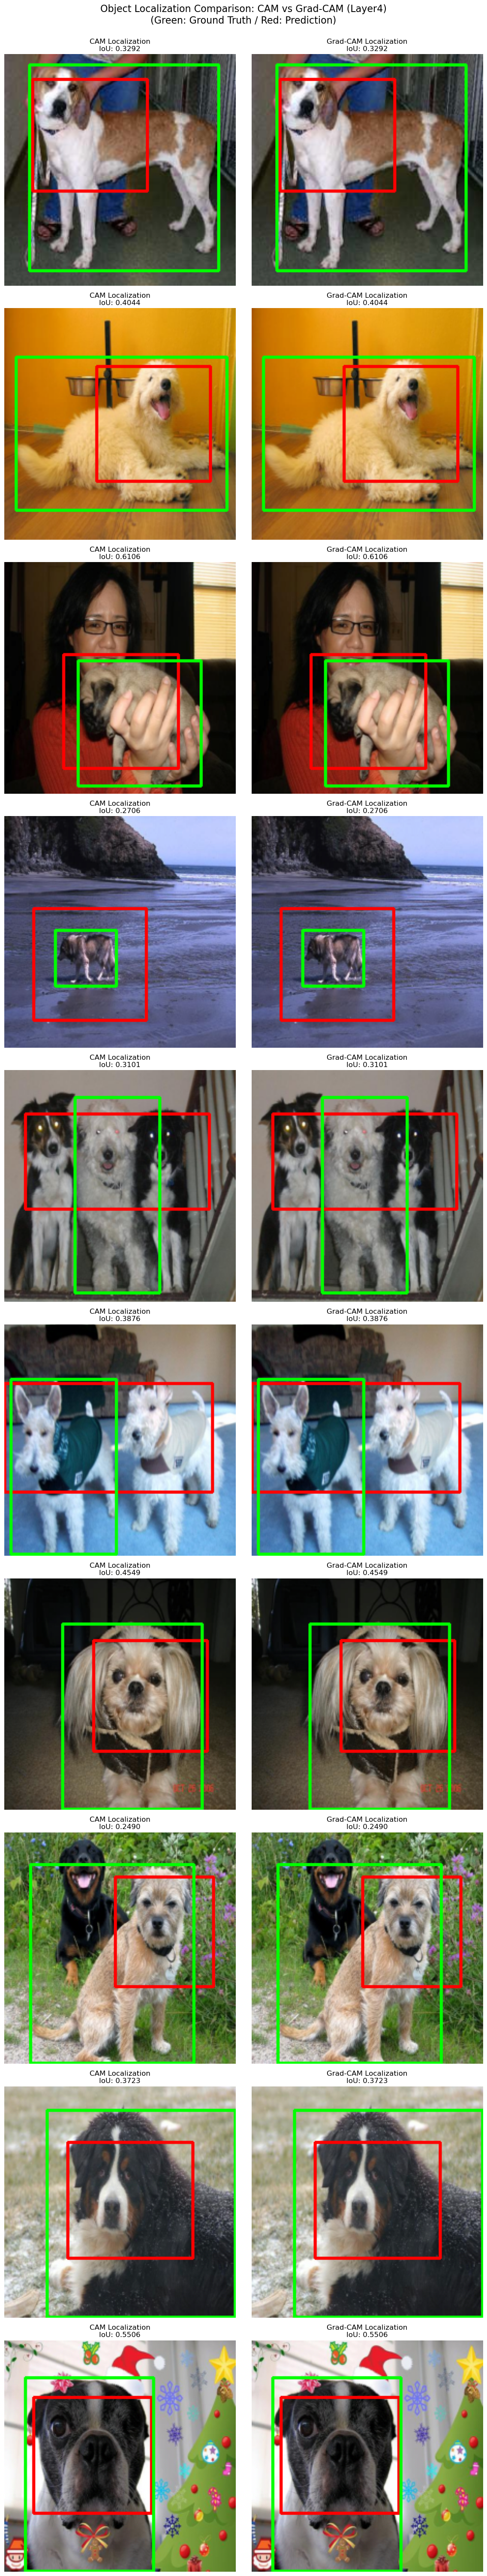

In [55]:
# 마찬가지로 여러개 비교하기 위해 Valid 데이터에서 k개 만큼 랜덤으로 추출
# 마찬가지로 subplots 사용해서 각 이미지에 대한 CAM과 Grad-CAM을 비교하기 용이하게 배열


num_samples = 10
indices = random.sample(range(len(valid_dataset)), num_samples)
threshold = 0.2

cam_iou_scores = []
grad_cam_iou_scores = []

fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6 * num_samples))
fig.suptitle("Object Localization Comparison: CAM vs Grad-CAM (Layer4)\n(Green: Ground Truth / Red: Prediction)", fontsize=16, y=1.00)

model.eval()

for i, idx in enumerate(indices):
    img_tensor, label, gt_bbox = valid_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    
    gt_bbox = [int(coord) for coord in gt_bbox]
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    orig_img_uint8 = (img_np * 255).astype(np.uint8)
    h, w, _ = orig_img_uint8.shape

    class_name = valid_dataset.classes[label].split('-')[-1]

    # ---------------------------------------------------------
    # CAM 기반 Localization
    # ---------------------------------------------------------
    cam_result = generate_cam(model, input_tensor)
    cam_map = cam_result[0] if isinstance(cam_result, tuple) else cam_result
    
    cam_resized = cv2.resize(cam_map, (w, h))
    
    pred_bbox_cam = get_bbox(cam_resized, threshold=threshold)
    
    iou_cam = get_iou(pred_bbox_cam, gt_bbox)
    cam_iou_scores.append(iou_cam)

    # 초록색이 정답 레이블, 빨간색이 예측 레이블
    # 엄밀히 말하면 Bounding Box 레이블
    if pred_bbox_cam is not None:
        img_viz_cam = visualize_both_bbox_on_image(orig_img_uint8, pred_bbox_cam, gt_bbox)
    else:
        img_viz_cam = orig_img_uint8.copy()

    axes[i, 0].imshow(img_viz_cam)
    axes[i, 0].set_title(f"CAM Localization\nIoU: {iou_cam:.4f}", fontsize=12)
    axes[i, 0].axis('off')

    # ---------------------------------------------------------
    # Grad-CAM 기반 Localization
    # ---------------------------------------------------------
    grad_cam_map = generate_grad_cam(model, input_tensor, target_layer_name='layer4')
    
    grad_cam_resized = cv2.resize(grad_cam_map, (w, h))
    
    pred_bbox_grad = get_bbox(grad_cam_resized, threshold=threshold)
    
    iou_grad = get_iou(pred_bbox_grad, gt_bbox)
    grad_cam_iou_scores.append(iou_grad)

    # 위와 동일하게 색상 적용
    if pred_bbox_grad is not None:
        img_viz_grad = visualize_both_bbox_on_image(orig_img_uint8, pred_bbox_grad, gt_bbox)
    else:
        img_viz_grad = orig_img_uint8.copy()

    axes[i, 1].imshow(img_viz_grad)
    axes[i, 1].set_title(f"Grad-CAM Localization\nIoU: {iou_grad:.4f}", fontsize=12)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [56]:
mean_iou_cam = np.mean(cam_iou_scores)
mean_iou_grad = np.mean(grad_cam_iou_scores)

print("="*50)
print(f" [Localization Performance Analysis (N={num_samples})]")
print("="*50)
print(f"1. CAM Mean IoU      : {mean_iou_cam:.4f}")
print(f"2. Grad-CAM Mean IoU : {mean_iou_grad:.4f}")
print(f"3. Difference        : {abs(mean_iou_cam - mean_iou_grad):.4f}")

 [Localization Performance Analysis (N=10)]
1. CAM Mean IoU      : 0.3939
2. Grad-CAM Mean IoU : 0.3939
3. Difference        : 0.0000
